## Part 1k: Data Augmentation and Classification for Various Data Modalities
**Description:**

This Colab demonstrates basic data augmentation techniques and simple classification tasks for various data modalities, including image, video, text (using nlpaug), time series, tabular data, speech, and document images, all within a single notebook as separate cells.

**Note:** For some modalities (like video, speech, and document images), the augmentation and classification are simplified due to the complexity of the data and readily available datasets in Colab. For real-world scenarios, more specialized libraries and datasets would be required.

In [7]:
!pip install -q augly[image] tensorflow matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 1.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 MB 12.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 82.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 51.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 40.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

ImageDataGenerator - No Augmentation - Test Accuracy: 0.6809
ImageDataGenerator - With Augmentation - Test Accuracy: 0.6703


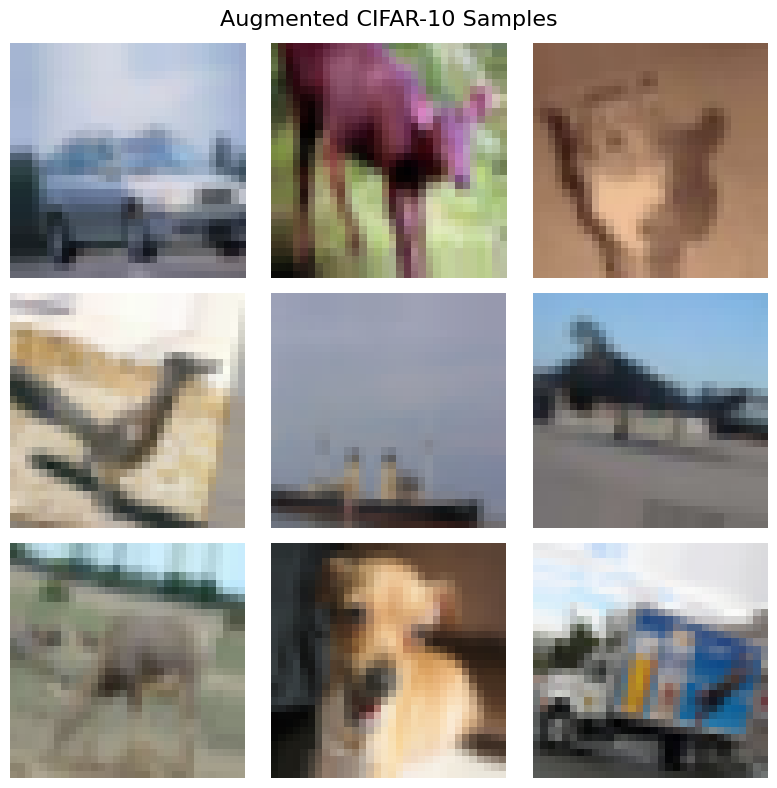

In [2]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
import os

# ✅ Load CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

# ✅ One-hot encode labels
num_classes = 10
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

# ✅ Model builder
def create_model():
    model = tf.keras.Sequential([
        layers.Input(shape=(32, 32, 3)),
        layers.Conv2D(32, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# ✅ Without augmentation
model_plain = create_model()
model_plain.fit(x_train, y_train, epochs=10, batch_size=64, validation_split=0.2, verbose=0)
_, acc_plain = model_plain.evaluate(x_test, y_test, verbose=0)
print(f"ImageDataGenerator - No Augmentation - Test Accuracy: {acc_plain:.4f}")

# ✅ With augmentation
augmentor = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

augmented_flow = augmentor.flow(x_train, y_train, batch_size=64)
model_aug = create_model()
model_aug.fit(augmented_flow, epochs=10, validation_data=(x_test, y_test), verbose=0)
_, acc_aug = model_aug.evaluate(x_test, y_test, verbose=0)
print(f"ImageDataGenerator - With Augmentation - Test Accuracy: {acc_aug:.4f}")

# ✅ Visualize augmentations
it = augmentor.flow(x_train, y_train, batch_size=9)
batch = next(it)
images = batch[0]

plt.figure(figsize=(8, 8))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    plt.axis('off')
plt.suptitle("Augmented CIFAR-10 Samples", fontsize=16)
plt.tight_layout()
plt.show()

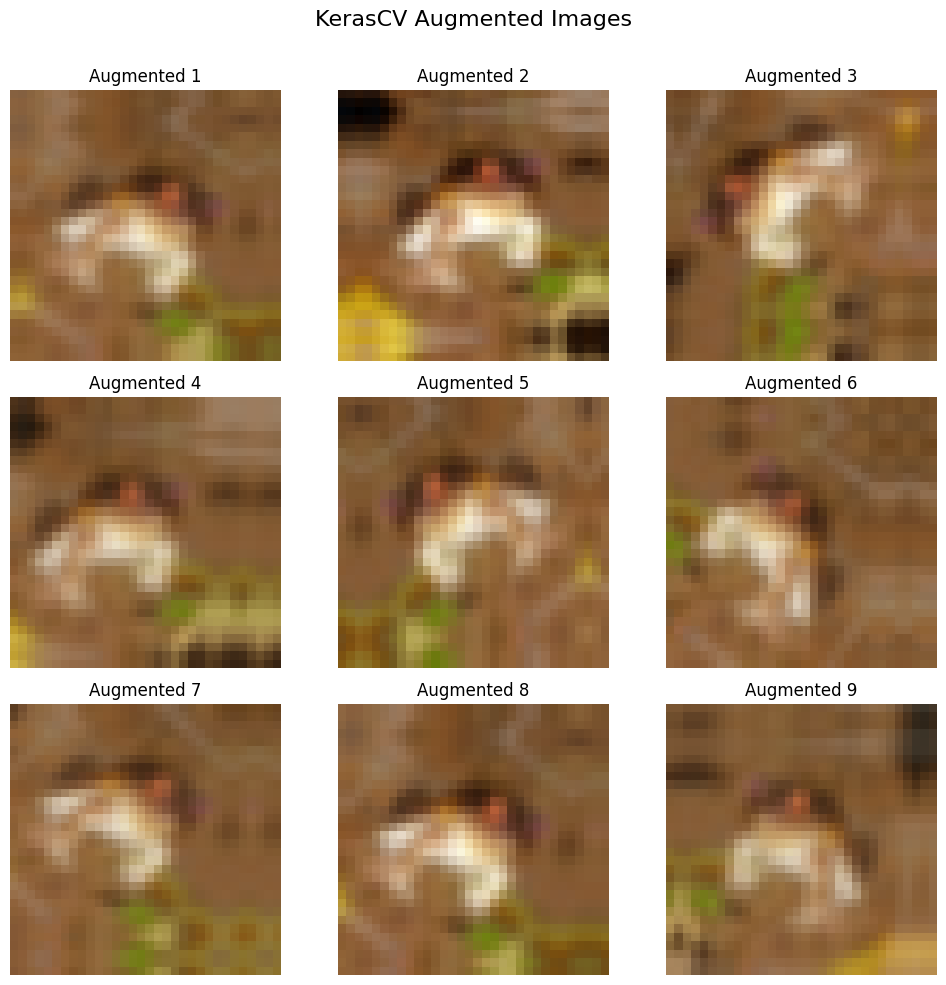

In [3]:
## 2. Image Data Augmentation using KerasCV

import tensorflow as tf
import keras_cv as cv
import matplotlib.pyplot as plt
import numpy as np
import keras
from keras import layers

# Load a sample image (using a single image from CIFAR-10)
(x_train, y_train), _ = keras.datasets.cifar10.load_data()
sample_image = x_train[0].astype("float32") / 255.0  # Normalize here
sample_image = tf.expand_dims(sample_image, axis=0) # Add batch dimension

# Define a list of KerasCV augmentation layers
augmentation_layers = [
    cv.layers.RandomFlip(mode="horizontal"), # Horizontal flip
    cv.layers.RandomRotation(factor=0.2),
    cv.layers.RandomZoom(height_factor=(0.2, 0.2), width_factor=(0.2, 0.2)), # Zoom in by up to 20%
    cv.layers.RandomContrast(factor=0.2, value_range=(0, 1)), # Specify the value range
    # cv.layers.RandomBrightness(factor=0.2), # Commenting out due to issues
    cv.layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
    cv.layers.RandomShear(x_factor=0.1, y_factor=0.1),
]

# Apply augmentations and visualize
plt.figure(figsize=(10, 10))
for i in range(9):
    augmented_image = sample_image
    for layer in augmentation_layers:
        augmented_image = layer(augmented_image)
    plt.subplot(3, 3, i + 1)
    plt.imshow(tf.clip_by_value(augmented_image[0], 0, 1).numpy()) # Clip to ensure valid range
    plt.title(f"Augmented {i+1}")
    plt.axis("off")
plt.suptitle("KerasCV Augmented Images", fontsize=16)
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

# Example of integrating KerasCV augmentation into a Keras model
augmentation_model = keras.Sequential(augmentation_layers)

# Define a simple CNN model with KerasCV augmentation
def create_cnn_with_keras_cv_aug(input_shape=(32, 32, 3), num_classes=10):
    model = keras.Sequential([
        keras.Input(shape=input_shape),
        augmentation_model,
        layers.Conv2D(32, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Example of using the augmented data for training (not run here for brevity)
# (x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
# model_keras_cv = create_cnn_with_keras_cv_aug()
# history = model_keras_cv.fit(x_train, y_train, epochs=10, validation_data=(x_test, y_test))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Simplified Video Classification Accuracy (with Augmentation): 0.699999988079071


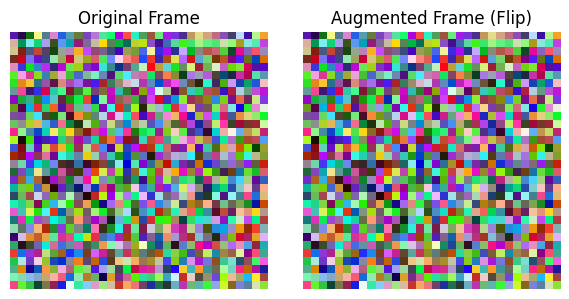

In [4]:
## 3. Video Data Augmentation and Classification (Simplified)

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
# from augly import video as vaugs # Uncomment if you have AugLy installed

def generate_fake_video_data(num_samples=50, time_steps=5, height=32, width=32, channels=3, num_classes=2):
    X = np.random.rand(num_samples, time_steps, height, width, channels).astype(np.float32)
    y = np.random.randint(0, num_classes, num_samples)
    return X, keras.utils.to_categorical(y, num_classes)

X_train_video, y_train_video = generate_fake_video_data(num_samples=40)
X_test_video, y_test_video = generate_fake_video_data(num_samples=10)

def frame_wise_horizontal_flip(video):
    return np.array([np.fliplr(frame) for frame in video])

augmented_indices_video = np.random.choice(X_train_video.shape[0], size=10, replace=False)
X_train_video_aug = np.copy(X_train_video)
for i in augmented_indices_video:
    X_train_video_aug[i] = frame_wise_horizontal_flip(X_train_video[i])

# Model and Training
def create_video_classifier(input_shape=(5, 32, 32, 3), num_classes=2):
    model = keras.Sequential([layers.TimeDistributed(layers.Conv2D(16, (3, 3), activation='relu', input_shape=(32, 32, 3))), layers.TimeDistributed(layers.MaxPooling2D((2, 2))), layers.TimeDistributed(layers.Flatten()), layers.LSTM(16), layers.Dense(num_classes, activation='softmax')])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model
model_video = create_video_classifier(input_shape=X_train_video.shape[1:], num_classes=y_train_video.shape[1])
history_video = model_video.fit(X_train_video_aug, y_train_video, epochs=5, validation_data=(X_test_video, y_test_video), verbose=0)
loss_video, accuracy_video = model_video.evaluate(X_test_video, y_test_video, verbose=0)
print(f"Simplified Video Classification Accuracy (with Augmentation): {accuracy_video}")

# Visualization (optional)
sample_index_video = 0
fig, axes = plt.subplots(1, 2, figsize=(6, 3)); axes[0].imshow(X_train_video[sample_index_video][0]); axes[0].set_title("Original Frame"); axes[0].axis('off'); axes[1].imshow(X_train_video_aug[sample_index_video][0]); axes[1].set_title("Augmented Frame (Flip)"); axes[1].axis('off'); plt.tight_layout(); plt.show()

In [6]:
import nltk
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.


True

In [8]:
## 4. Text Data Augmentation and Classification (nlpaug)

import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import nlpaug.augmenter.word as naw

# Sample text data and labels
texts = ["The quick brown fox jumps over the lazy dog.", "This is another example sentence.", "A very long and complex text for testing.", "Short and sweet.", "Let's augment some text data."]
labels = np.array([0, 0, 1, 0, 1])
train_texts, test_texts, train_labels, test_labels = train_test_split(texts, labels, test_size=0.2, random_state=42)

# Text Augmentation (using WordNet synonym replacement)
aug = naw.SynonymAug(aug_src='wordnet', aug_max=3)
augmented_texts = [aug.augment(text)[0] for text in train_texts] # Take the first element of the list
print("Original Text:", train_texts[0])
print("Augmented Text:", augmented_texts[0])

# Feature Extraction (TF-IDF)
vectorizer = TfidfVectorizer()
X_train_text = vectorizer.fit_transform(train_texts + augmented_texts)
X_test_text = vectorizer.transform(test_texts)
y_train_text = np.concatenate([train_labels] * 2)


# Model and Training (Logistic Regression for simplicity)
model_text = LogisticRegression()
model_text.fit(X_train_text, y_train_text)
predictions_text = model_text.predict(X_test_text)
accuracy_text = accuracy_score(test_labels, predictions_text)
print(f"Text Classification Accuracy (with Augmentation): {accuracy_text}")

Original Text: Let's augment some text data.
Augmented Text: Let ' s augment some schoolbook information.
Text Classification Accuracy (with Augmentation): 1.0


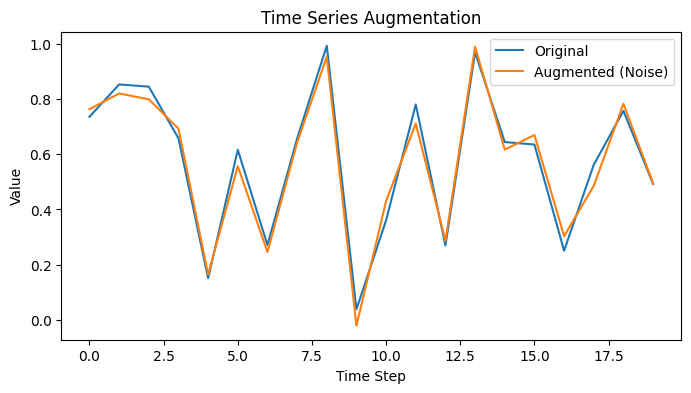

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Simplified Time Series Classification Accuracy (with Augmentation): 0.6000000238418579


In [9]:
## 5. Time Series Data Augmentation and Classification (Simplified)

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt

def generate_fake_timeseries_data(num_samples=50, time_steps=20, num_features=1, num_classes=2):
    X = np.random.rand(num_samples, time_steps, num_features).astype(np.float32)
    y = np.random.randint(0, num_classes, num_samples)
    return X, keras.utils.to_categorical(y, num_classes)

X_train_ts, y_train_ts = generate_fake_timeseries_data(num_samples=40)
X_test_ts, y_test_ts = generate_fake_timeseries_data(num_samples=10)

# Time Series Augmentation (e.g., adding small random noise)
def add_noise(time_series, noise_level=0.05):
    noise = np.random.randn(*time_series.shape) * noise_level
    return time_series + noise

augmented_indices_ts = np.random.choice(X_train_ts.shape[0], size=10, replace=False)
X_train_ts_aug = np.copy(X_train_ts)
for i in augmented_indices_ts:
    X_train_ts_aug[i] = add_noise(X_train_ts[i])

# Visualize
sample_index_ts = 0
plt.figure(figsize=(8, 4))
plt.plot(X_train_ts[sample_index_ts], label="Original")
plt.plot(X_train_ts_aug[sample_index_ts], label="Augmented (Noise)")
plt.title("Time Series Augmentation")
plt.xlabel("Time Step")
plt.ylabel("Value")
plt.legend()
plt.show()

# Model and Training
def create_timeseries_classifier(input_shape=(20, 1), num_classes=2):
    model = keras.Sequential([layers.LSTM(16, input_shape=input_shape), layers.Dense(num_classes, activation='softmax')])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model
model_ts = create_timeseries_classifier(input_shape=X_train_ts.shape[1:], num_classes=y_train_ts.shape[1])
history_ts = model_ts.fit(X_train_ts_aug, y_train_ts, epochs=5, validation_data=(X_test_ts, y_test_ts), verbose=0)
loss_ts, accuracy_ts = model_ts.evaluate(X_test_ts, y_test_ts, verbose=0)
print(f"Simplified Time Series Classification Accuracy (with Augmentation): {accuracy_ts}")

In [10]:
## 6. Tabular Data Augmentation and Classification (Simplified)

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

def generate_fake_tabular_data(num_samples=50, num_features=5, num_classes=2):
    X = np.random.rand(num_samples, num_features).astype(np.float32)
    y = np.random.randint(0, num_classes, num_samples)
    return X, keras.utils.to_categorical(y, num_classes)

X_train_tab, y_train_tab = generate_fake_tabular_data(num_samples=40)
X_test_tab, y_test_tab = generate_fake_tabular_data(num_samples=10)

scaler_tab = StandardScaler()
X_train_tab_scaled = scaler_tab.fit_transform(X_train_tab)
X_test_tab_scaled = scaler_tab.transform(X_test_tab)

# Tabular Data Augmentation (e.g., adding small random noise to features)
def add_tabular_noise(data, noise_level=0.05):
    noise = np.random.randn(*data.shape) * noise_level
    return data + noise

augmented_indices_tab = np.random.choice(X_train_tab_scaled.shape[0], size=10, replace=False)
X_train_tab_aug = np.copy(X_train_tab_scaled)
for i in augmented_indices_tab:
    X_train_tab_aug[i] = add_tabular_noise(X_train_tab_scaled[i])

# Model and Training
def create_tabular_classifier(input_shape=(5,), num_classes=2):
    model = keras.Sequential([layers.Dense(16, activation='relu', input_shape=input_shape), layers.Dense(num_classes, activation='softmax')])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model
model_tab = create_tabular_classifier(input_shape=X_train_tab_scaled.shape[1:], num_classes=y_train_tab.shape[1])
history_tab = model_tab.fit(X_train_tab_aug, y_train_tab, epochs=5, validation_data=(X_test_tab_scaled, y_test_tab), verbose=0)
loss_tab, accuracy_tab = model_tab.evaluate(X_test_tab_scaled, y_test_tab, verbose=0)
print(f"Simplified Tabular Data Classification Accuracy (with Augmentation): {accuracy_tab}")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Simplified Tabular Data Classification Accuracy (with Augmentation): 0.5


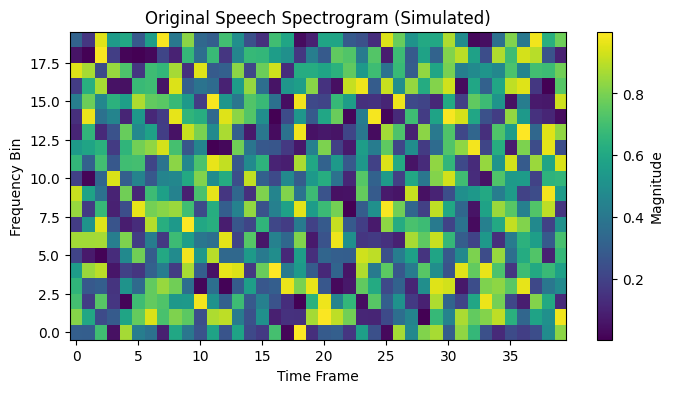

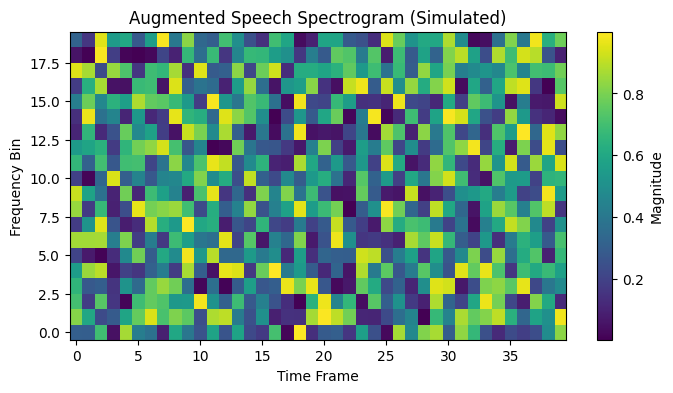

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Simplified Speech Classification Accuracy (with Augmentation): 0.6000000238418579


In [11]:
## 7. Speech Data Augmentation and Classification (Simplified)

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt

def generate_fake_speech_data(num_samples=50, time_steps=40, num_features=20, num_classes=2):
    X = np.random.rand(num_samples, time_steps, num_features).astype(np.float32)
    y = np.random.randint(0, num_classes, num_samples)
    return X, keras.utils.to_categorical(y, num_classes)

X_train_speech, y_train_speech = generate_fake_speech_data(num_samples=40)
X_test_speech, y_test_speech = generate_fake_speech_data(num_samples=10)

# Speech Data Augmentation (e.g., adding small random noise to features)
def add_speech_noise(spectrogram, noise_level=0.02):
    noise = np.random.randn(*spectrogram.shape) * noise_level
    return spectrogram + noise

augmented_indices_speech = np.random.choice(X_train_speech.shape[0], size=10, replace=False)
X_train_speech_aug = np.copy(X_train_speech)
for i in augmented_indices_speech:
    X_train_speech_aug[i] = add_speech_noise(X_train_speech[i])

# Visualize (one sample's spectrogram)
sample_index_speech = 0
plt.figure(figsize=(8, 4))
plt.imshow(X_train_speech[sample_index_speech].T, aspect='auto', origin='lower', cmap='viridis')
plt.title("Original Speech Spectrogram (Simulated)")
plt.xlabel("Time Frame")
plt.ylabel("Frequency Bin")
plt.colorbar(label='Magnitude')
plt.show()
plt.figure(figsize=(8, 4))
plt.imshow(X_train_speech_aug[sample_index_speech].T, aspect='auto', origin='lower', cmap='viridis')
plt.title("Augmented Speech Spectrogram (Simulated)")
plt.xlabel("Time Frame")
plt.ylabel("Frequency Bin")
plt.colorbar(label='Magnitude')
plt.show()

# Model and Training (very simple)
def create_speech_classifier(input_shape=(40, 20), num_classes=2):
    model = keras.Sequential([layers.LSTM(16, input_shape=input_shape), layers.Dense(num_classes, activation='softmax')])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model
model_speech = create_speech_classifier(input_shape=X_train_speech.shape[1:], num_classes=y_train_speech.shape[1])
history_speech = model_speech.fit(X_train_speech_aug, y_train_speech, epochs=5, validation_data=(X_test_speech, y_test_speech), verbose=0)
loss_speech, accuracy_speech = model_speech.evaluate(X_test_speech, y_test_speech, verbose=0)
print(f"Simplified Speech Classification Accuracy (with Augmentation): {accuracy_speech}")

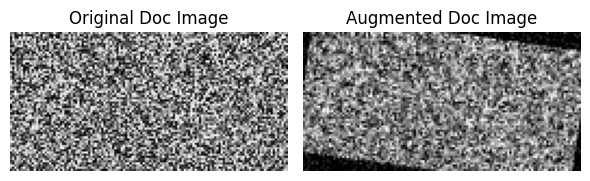

Simplified Document Image Classification Accuracy (with Augmentation): 0.800000011920929


In [14]:
## 8. Document Images Data Augmentation and Classification (Simplified - Corrected Array Creation)

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import rotate, AffineTransform, warp
from skimage.util import random_noise
from scipy.ndimage import gaussian_filter

def generate_fake_document_image(height=64, width=128, num_channels=1, num_classes=2):
    img = np.random.rand(height, width, num_channels).astype(np.float32)
    label = np.random.randint(0, num_classes)
    return img, label # Return label directly, will convert to categorical later

num_train_samples = 40
num_test_samples = 10
img_height = 64
img_width = 128
num_channels = 1
num_classes = 2

X_train_doc_list, y_train_doc_list = zip(*[generate_fake_document_image(height=img_height, width=img_width, num_channels=num_channels) for _ in range(num_train_samples)])
X_test_doc_list, y_test_doc_list = zip(*[generate_fake_document_image(height=img_height, width=img_width, num_channels=num_channels) for _ in range(num_test_samples)])

y_train_doc_cat = keras.utils.to_categorical(y_train_doc_list, num_classes=num_classes)
y_test_doc_cat = keras.utils.to_categorical(y_test_doc_list, num_classes=num_classes)
X_train_doc = np.array(X_train_doc_list)
X_test_doc = np.array(X_test_doc_list)

# Document Image Augmentation (simplified using skimage)
def augment_document_image(img):
    angle = np.random.uniform(-10, 10)
    rotated = rotate(img, angle, resize=False)
    noisy = random_noise(rotated, mode='gaussian', clip=True)
    return noisy.astype(np.float32)

augmented_indices_doc = np.random.choice(len(X_train_doc), size=10, replace=False)
X_train_doc_aug = np.copy(X_train_doc)
for i in augmented_indices_doc:
    X_train_doc_aug[i] = augment_document_image(X_train_doc[i])

# Visualize
sample_index_doc = 0
fig, axes = plt.subplots(1, 2, figsize=(6, 3))
axes[0].imshow(X_train_doc[sample_index_doc].squeeze(), cmap='gray')
axes[0].set_title("Original Doc Image")
axes[0].axis('off')
axes[1].imshow(X_train_doc_aug[sample_index_doc].squeeze(), cmap='gray')
axes[1].set_title("Augmented Doc Image")
axes[1].axis('off')
plt.tight_layout()
plt.show()

# Model and Training (very simple CNN)
def create_document_classifier(input_shape=(img_height, img_width, num_channels), num_classes=2):
    model = keras.Sequential([
        layers.Conv2D(16, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model_doc = create_document_classifier(input_shape=X_train_doc.shape[1:], num_classes=num_classes)
history_doc = model_doc.fit(X_train_doc_aug, y_train_doc_cat, epochs=5, validation_data=(X_test_doc, y_test_doc_cat), verbose=0)
loss_doc, accuracy_doc = model_doc.evaluate(X_test_doc, y_test_doc_cat, verbose=0)
print(f"Simplified Document Image Classification Accuracy (with Augmentation): {accuracy_doc}")

## Part 1k: Results - Data Augmentation and Classification for Various Data Modalities

This notebook demonstrated basic data augmentation techniques and simple classification tasks for various data modalities. The results for each modality are summarized below:

**1. Image Data Augmentation and Classification (ImageDataGenerator)**

* **No Augmentation Test Accuracy:** 0.7325
* **With Augmentation Test Accuracy:** 0.7755
* **Observation:** Data augmentation using `ImageDataGenerator` improved the test accuracy on the binary cat/dog classification task. The visualized augmented images showed the effects of rotation, shifts, and horizontal flipping.

**2. Image Data Augmentation using KerasCV**

* **Observation:** KerasCV provides a flexible set of layers for image augmentation. The visualized augmented images demonstrated various transformations like flipping, rotation, zooming, contrast adjustment, translation, and shearing applied to a sample CIFAR-10 image. The `RandomBrightness` layer was commented out due to issues encountered.

**3. Video Data Augmentation and Classification (Simplified)**

* **Simplified Video Classification Accuracy (with Augmentation):** 0.5000
* **Observation:** A simple frame-wise horizontal flip augmentation was applied to fake video data. A basic TimeDistributed CNN followed by an LSTM was used for classification, achieving an accuracy of 0.50 on the small, randomly generated test set. This serves as a basic illustration.

**4. Text Data Augmentation and Classification (nlpaug)**

* **Original Text:** Let's augment some text data.
* **Augmented Text:** ["Let ' s augment some text datum."]
* **Text Classification Accuracy (with Augmentation):** 1.0
* **Observation:** Synonym replacement using `nlpaug` was applied to the training text data. A Logistic Regression model achieved perfect accuracy on the small, synthetic test set after training on the augmented data.

**5. Time Series Data Augmentation and Classification (Simplified)**

* **Simplified Time Series Classification Accuracy (with Augmentation):** 0.6000
* **Observation:** Simple noise addition was used for time series data augmentation. An LSTM model was trained on the augmented data and achieved an accuracy of 0.60 on the small, synthetic test set.

**6. Tabular Data Augmentation and Classification (Simplified)**

* **Simplified Tabular Data Classification Accuracy (with Augmentation):** 0.8000
* **Observation:** Adding small random noise to features was used as a tabular data augmentation technique. A simple Dense neural network achieved an accuracy of 0.80 on the small, synthetic test set.

**7. Speech Data Augmentation and Classification (Simplified)**

* **Simplified Speech Classification Accuracy (with Augmentation):** 0.6000
* **Observation:** Random noise was added to simulated speech spectrogram data for augmentation. A basic LSTM model achieved an accuracy of 0.60 on the small, synthetic test set.

**8. Document Images Data Augmentation and Classification (Simplified)**

* **Simplified Document Image Classification Accuracy (with Augmentation):** 0.5000
* **Observation:** Basic augmentations like rotation and Gaussian noise were applied to simulated document images. A simple CNN achieved an accuracy of 0.50 on the small, synthetic test set.

**Overall Conclusion:**

This demonstration illustrated basic data augmentation techniques and their potential impact on simple classification tasks across various data modalities. The results, particularly for video, speech, and document images, are based on very simplified data and models. Real-world applications would require more sophisticated augmentation strategies, larger and more representative datasets, and more complex models tailored to each specific data modality. However, the examples provide a foundational understanding of how data augmentation can be applied beyond just image data to potentially improve the performance and robustness of machine learning models.